In [1]:
#hide
from autoneuro.calculators import TestCalculator
import pandas as pd
import numpy as np
import seaborn as sbn

# AutoNeuro

> A tool for calculating neurological scores based on demographically adjusted norms.

![autoneuro diagram](./imgs/diagram.png)

Due to the varied nature of these neurological tests it is often difficult to process these for research purposes.
This library is an attempt to standardize the test calculation and normalization process.
It also handles common visualization, machine learning integrations, and synthetic data generation.
At this point in development, it should not be used for diagnostic purposes.

## How to use

 - Clinical researchers (Mike, Vanessa) start with this `clinical_explanation` instead.
 - Neurological researchers (Kate) start with the `domains` documentation.

Computational researchers continue reading.

### Install
> Please don't yet. Highly unstable.

`git clone https://github.com/JudoWill/autoneuro/`

`pip install -r requirements.pip`

### Use Case

`Autoneuro` is intended to function as a layer for converting raw measurement data from neuro-tests into normalized data.
Normalization schemes can be built on the fly, but most commonly, you'll start with pre-defined normalization schemes.
These are described in `yaml` files within the `data/` directory of the github repo.
Which look like:

In [2]:
!cat data/test_calculators/BVMT.yaml

name: 'Brief Visiospatial Memory Test'
short_name: 'BVMT'


operations:
  - type: equation
    equation: 'trial1+trial2+trial3'
    fields: ['trial1', 'trial2', 'trial3']
    out_field: immediate
  - type: agg
    method: 'max'
    fields: ['trial2', 'trial3']
    out_field: retention_denom
  - type: equation
    equation: 'delay/retention_denom'
    fields: [ 'delay', 'retention_denom']
    out_field: retention
  - type: clip
    field: retention
    lower: 0
    upper: 1
  - type: equation
    equation: 'hits-false_pos'
    fields: ['hits', 'false_pos']
    out_field: 'recognition'



These can be parsed with `pyyaml` and fed to the `from_config` method on most types of objects.

This builds a `TestCalculator` that can calculate intermediate BVMT values from raw measurements.

In [3]:
import yaml

bvmt_config = yaml.full_load(open('data/test_calculators/BVMT.yaml'))
bvmt_calc = TestCalculator.from_config(bvmt_config)

Once created, this `TestCalculator` can be used to explain any set of calculations.

In [4]:
DATA = {'trial1': 5, 'trial2': 6, 'trial3': 7,
        'delay': 8, 'hits': 6, 'false_pos': 2,
        'copy': 12}

bvmt_calc.explain(DATA)

Taking: delay:8, false_pos:2, hits:6, trial1:5, trial2:6, trial3:7
Used Equation: trial1+trial2+trial3 = 18 = immediate
Aggregation: max [trial2, trial3]  = 7
Used Equation: delay/retention_denom = 1.1428571428571428 = retention
Clipped retention to [0, 1]
Used Equation: hits-false_pos = 4.0 = recognition
Resulting in: immediate:18.0, recognition:4.0, retention:1.0, retention_denom:7.0


These can then be combined with calculators that define age based norms (`heaton`) or regression norms (`norman`).

Like so:

In [5]:
heaton_norm_definition = 'data/norms/from_kate/heaton_bvmt.yaml'
heaton_bvmt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_norm_definition)))

norman_scaling_definition = 'data/norms/norman/norman_scaling.yaml'
norman_scale = TestCalculator.from_config(yaml.full_load(open(norman_scaling_definition)))

norman_regression_definition = 'data/norms/norman/norman_bvmt_regnorm.yaml'
reg_calc = TestCalculator.from_config(yaml.full_load(open(norman_regression_definition)))

# Calculators can be added to combine their operations.
full_bvmt_calc = bvmt_calc + heaton_bvmt_calc + norman_scale + reg_calc

DATA = {'trial1': 5, 'trial2': 6, 'trial3': 7,
        'delay': 8, 'hits': 6, 'false_pos': 2,
        'copy': 12, 'age': 32, 'gender': 'male',
        'race': 'AA', 'education': 12}

full_bvmt_calc.explain(DATA)

Taking: age:32, delay:8, education:12, false_pos:2, gender:male, hits:6, race:AA, trial1:5, trial2:6, trial3:7
Used Equation: trial1+trial2+trial3 = 18 = immediate
Aggregation: max [trial2, trial3]  = 7
Used Equation: delay/retention_denom = 1.1428571428571428 = retention
Clipped retention to [0, 1]
Used Equation: hits-false_pos = 4 = recognition
heaton_immediate: Matched (30 <= age) & (age <= 33), Expecting 26.92 +- 4.64, Observed: 18
heaton_retention: Matched (30 <= age) & (age <= 33), Expecting 0.962 +- 0.0474, Observed: 1.0
heaton_delay: Matched (30 <= age) & (age <= 33), Expecting 10.13 +- 1.6, Observed: 8
heaton_recognition: Matched (30 <= age) & (age <= 33), Expecting 5.97 +- 0.15, Observed: 4
gender:male -> norman_gender:0
race:AA -> norman_race:1
delay matched 8, scaled to 7
immediate matched 16, scaled to 6
gender:male -> norman_gender:0
race:AA -> norman_race:1
delay matched 8, scaled to 7
immediate matched 16, scaled to 6
Matched (norman_race == 1) & ((age >= 18) & (age <= 

These can also be run across `pd.DataFrame` objects.
This can be useful for either processing larger datasets or examining how one variable influences the score.

,delay,heaton_delay,norman_delay
0,2,-5.08125,-2.523492
1,2,-5.08125,-2.523492
2,2,-5.08125,-2.523492
3,4,-3.83125,-1.729747
4,7,-1.95625,-0.936002


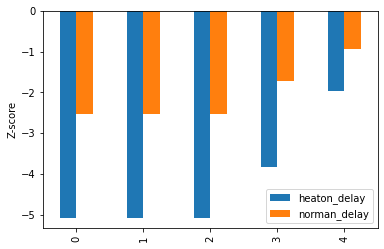

In [8]:
# Keep the same scores, but change the age.
df = pd.DataFrame([DATA]*5)
df['delay'] = np.random.randint(0, 8, size=(5,))

data = full_bvmt_calc.process_dataframe(df)
ax = data.plot(y = ['heaton_delay', 'norman_delay'], kind = 'bar')
ax.set_ylabel('Z-score')

cols = ['delay', 'heaton_delay', 'norman_delay']
data[cols].head()


### General Organization

 - `domains` are the "largest" object and manage collections of multiple tests. 
 If you're building visualizations and exploring large collections, use these.
 - `calculators` are collections of operations and utilities for processing raw data. 
 If you are just normalizing data for downstream tasks like ML, use these.
 - `operators` are the functional units of calculators. 
 Unless you're Will, you probably don't need to be in here. 
 - `normative_data` is currently stored in the data/norms directory as yaml formats.
 Refer here (tbd) for an explanation of the YAML format.
  